### Imports

In [1]:
from utils.ml_utils import draw_decision_tree
import utils.clustering_utils as cluster
import pandas as pd

### Read DFs

In [2]:
# account = pd.read_csv('../data/account.csv', delimiter=';')
# disp = pd.read_csv('../data/disp.csv', delimiter=';')
# client = pd.read_csv('../data/client.csv', delimiter=';')
# district = pd.read_csv('../data/district.csv', delimiter=';')
# card_dev = pd.read_csv('../data/card_dev.csv', delimiter=';')
# trans_dev = pd.read_csv('../data/trans_dev.csv', delimiter=';', dtype={'bank': str})

# dfs = [
#     account,
#     disp,
#     client,
#     district,
#     card_dev,
#     trans_dev
# ]
# df = cluster.merge_transactions_clients(dfs)

In [3]:
df = pd.read_csv('../data/clean/df-train.csv')
# df.columns

### Clustering

In this section we will try to find groups of clients or transactions. To do that, we will use PCA alongside KMeans.

PCA is used to reduce the dimensionality of our features.

KMeans was used to generate the clusters because it is a fast algorithm and it uses a stochastic approach that frequently works well.

#### Clients

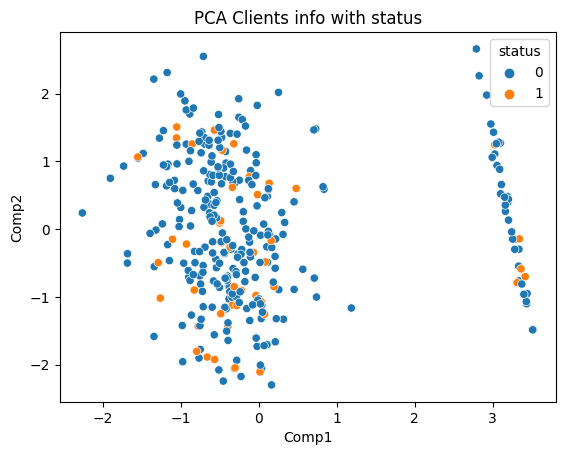

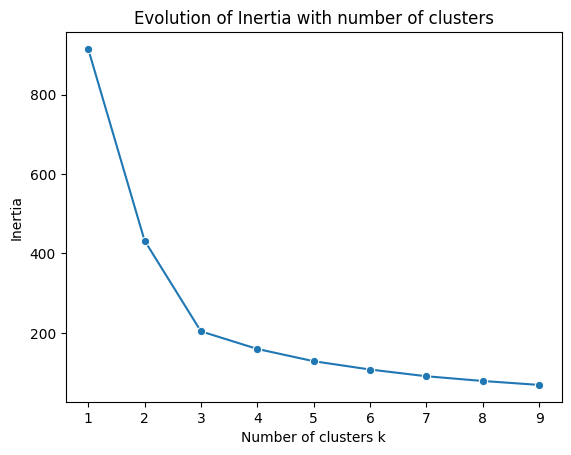

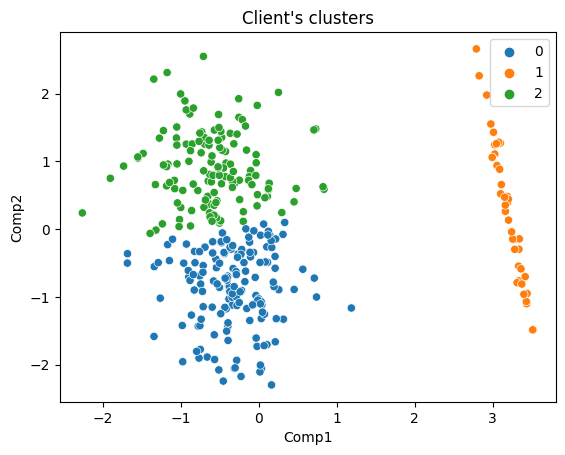

**KMeans Clusters:**
- Counter({0: 153, 2: 134, 1: 41})

**KMeans Centers:**
- [[-0.3330034  -0.8659636 ]
 [ 3.19851853  0.2781153 ]
 [-0.5984309   0.9036545 ]]

**KMeans Inertia:**
- 203.72980510159908

**KMeans Silhouette Score:**
- 0.5137619650542989

,gender,age,average_salary,criminality_growth,avg_balance
cluster,,,,,
0,0.732026,68.091503,9127.156863,0.000432,36190.756295
1,0.609756,65.195122,12541.000000,0.011146,42203.971194
2,0.216418,57.119403,9051.917910,0.000829,51735.236802


In [4]:
cluster_feature_mean = cluster.clustering_clients(df)
cluster_feature_mean